# Read in the data

In [2]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("../data/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("../data//survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("../data/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# 1: Introduction

Over the last three missions, we explored relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:

    SAT scores by school - SAT scores for each high school in New York City
    School attendance - Attendance information for each school in New York City
    Class size - Information on class size for each school
    AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
    Graduation outcomes - The percentage of students who graduated, and other outcome information
    Demographics - Demographic information for each school
    School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

In the last mission, we began performing some analysis. We'll extend that analysis in this mission. As you can see, we've included the code to read in all of the data, combine it, and create correlations in the notebook. If you'd like to see the finished notebook that contains solutions for all of the steps, you can find it in the GitHub repo for this mission.

The dataframe combined contains all of the data we'll be using in our analysis.

## Instructions

    Set up matplotlib to work in Jupyter notebook.
    There are several fields in combined that originally came from a survey of parents, teachers, and students. Make a bar plot of the correlations between these fields and sat_score.
        You can find a list of the fields in the survey_fields variable in the notebook.
    Consult the data dictionary that's part of the zip file you can download from the City of New York's website.
        Did you find any surprising correlations?
    Write up your results in a Markdown cell.

In [11]:
%matplotlib inline

In [12]:
import matplotlib.pyplot as plt

corr_output = combined.corr()
sat_score_corr = corr_output['sat_score']
print ( type( sat_score_corr ))

survey_list = []
sat_corr= []

for key, value in sat_score_corr.iteritems():
    if key in survey_fields:
        survey_list.append( key )
        sat_corr.append( value )

<class 'pandas.core.series.Series'>


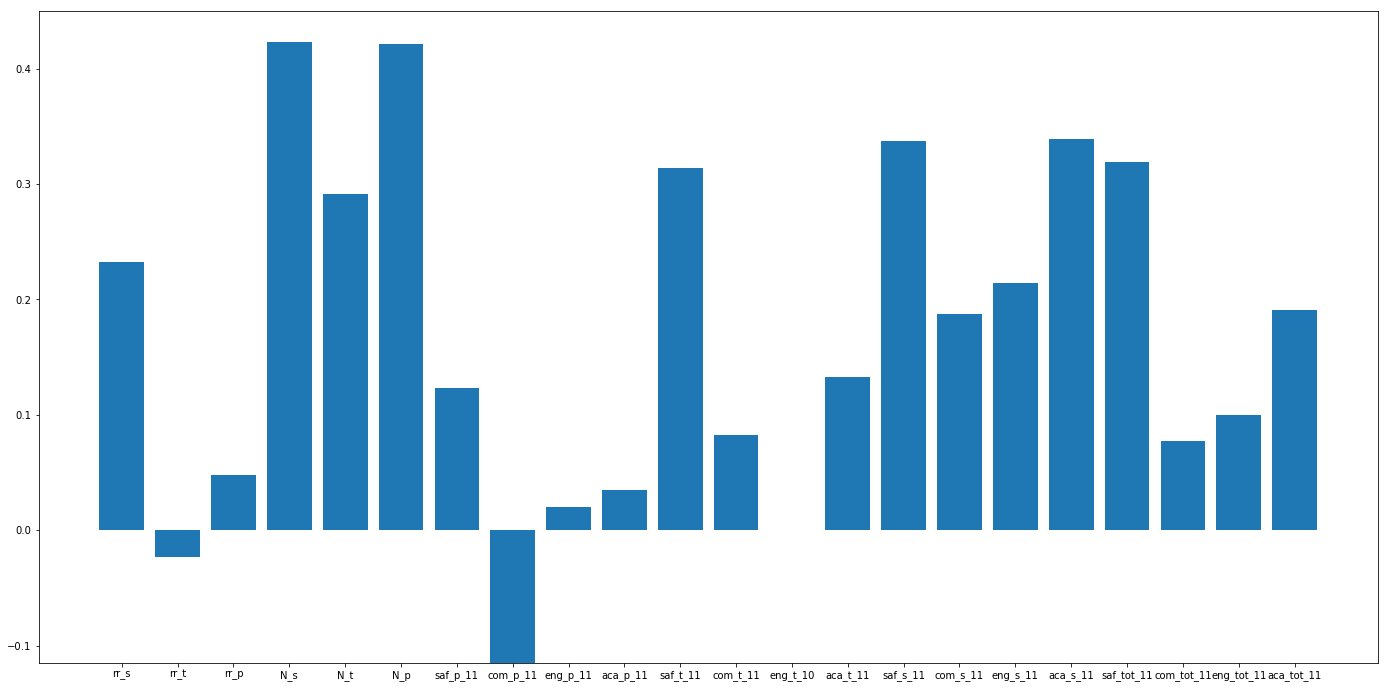

In [13]:
from pylab import *

x_axis_list = range( 0, len( sat_corr ) )
plt.figure( figsize=( 24, 12 ) )
plt.bar( x_axis_list, sat_corr )
plt.xticks( arange( len(survey_list )), survey_list )
plt.show()

# HIGHEST CORRELATION COLUMNS

- N_s Number of student respondents
- N_t Number of teachers respondents
- N_p Number of parents respondents
- saf_t_11 How teachers perceive safety
- saf_s_11 How student perceive safety
- acs_s_11 Academic expectations score based on student responses



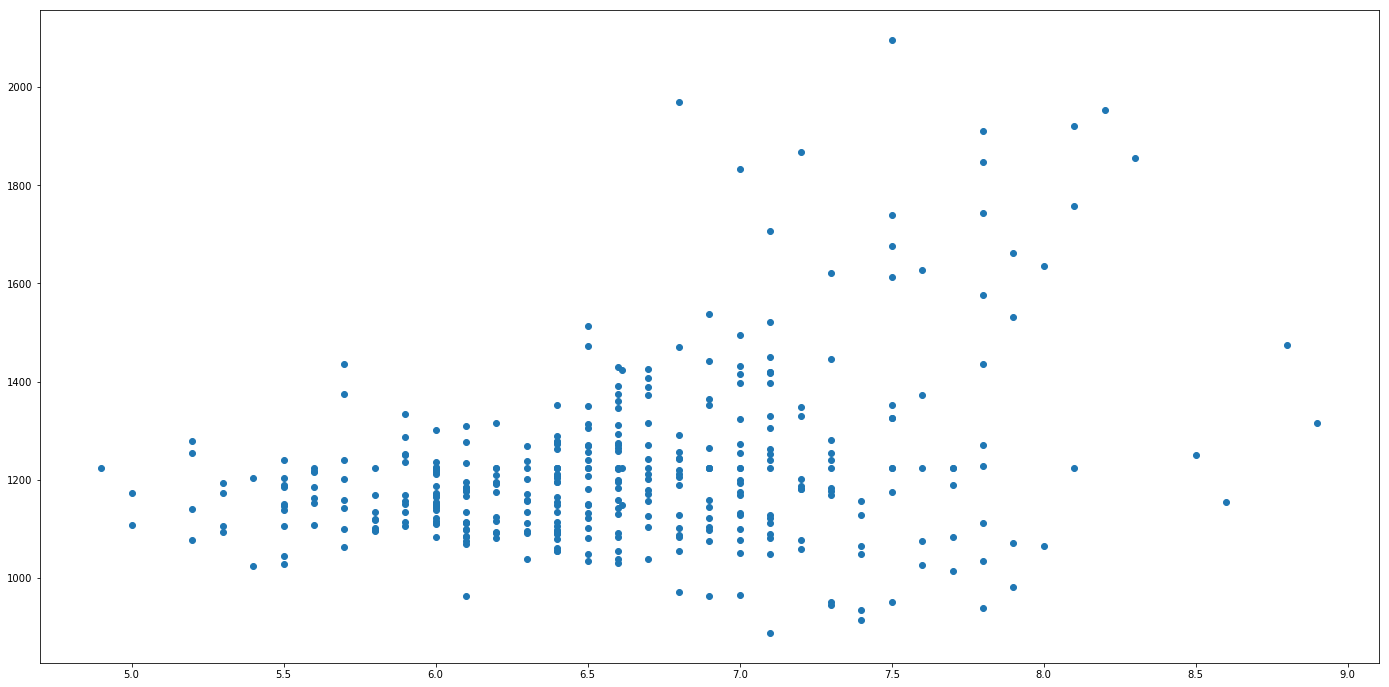

In [16]:
# saf_s_11 column vs. the sat_score
plt.figure( figsize=( 24, 12 ) )
plt.scatter( combined['saf_s_11'], combined['sat_score'])
plt.show()

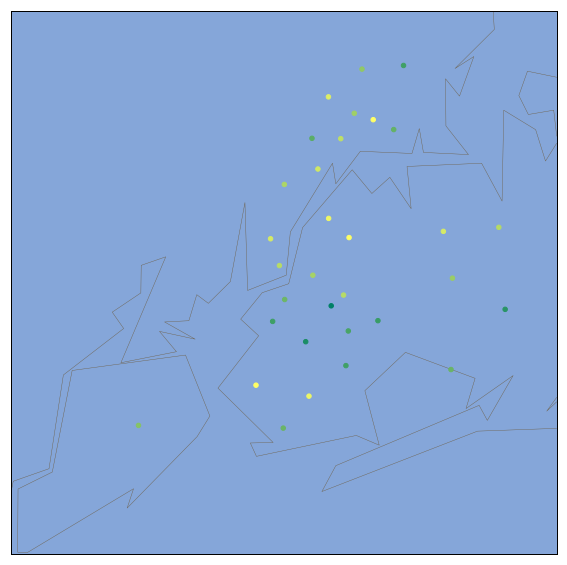

In [21]:
import numpy

districts = combined.groupby( 'school_dist').agg( numpy.mean )
districts.reset_index( inplace=True )

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

plt.figure( figsize=( 10, 10 ))
m.drawmapboundary( fill_color='#85A6D9' )
m.drawcoastlines( color='#6D5F47', linewidth=.4 )
m.drawrivers( color='#6D5F47', linewidth=.4 )

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter( longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer" )

plt.show()


# 3: Exploring Race and SAT Scores

There are a few columns that indicate the percentage of each race at a given school:

    white_per
    asian_per
    black_per
    hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

## Instructions

    Investigate racial differences in SAT scores.
        Make a bar plot of the correlations between the columns above and sat_score.
        Write up a Markdown cell containing your findings. Are there any unexpected correlations?
    Explore schools with low SAT scores and high values for hispanic_per.
        Make a scatter plot of hispanic_per vs. sat_score.
        What does the scatter plot show? Record any interesting observsations in a Markdown cell.
    Research any schools with a hispanic_per greater than 95%.
        Find the school names in the data.
        Use Wikipedia and Google to research the schools by name.
        Is there anything interesting about these particular schools? Record your findings in a Markdown cell.
    Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.
        Find the school names in the data.
        Use Wikipedia and Google to research the schools by name.
        Is there anything interesting about these particular schools? Record your findings in a Markdown cell.


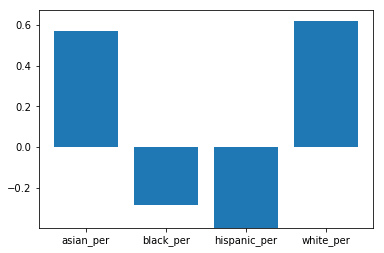

In [23]:
race_list = [ 'white_per',
'asian_per',
'black_per',
'hispanic_per' ]

int_list = range( len ( race_list ) )

corr_list = combined.corr()
sat_score_corr = corr_list['sat_score']

race_name_list = []
race_corr_list = []

for key,value in sat_score_corr.iteritems():
    if key in race_list:
        race_name_list.append( key )
        race_corr_list.append( value )
        
plt.xticks( arange( len(int_list )), race_name_list )
plt.bar( int_list, race_corr_list )
plt.show()

## Finding stuff in the bar plot above

- Asians and white have very positive correlation with sat_score
- Back and hispance have signifiently negative correlation with sat_score

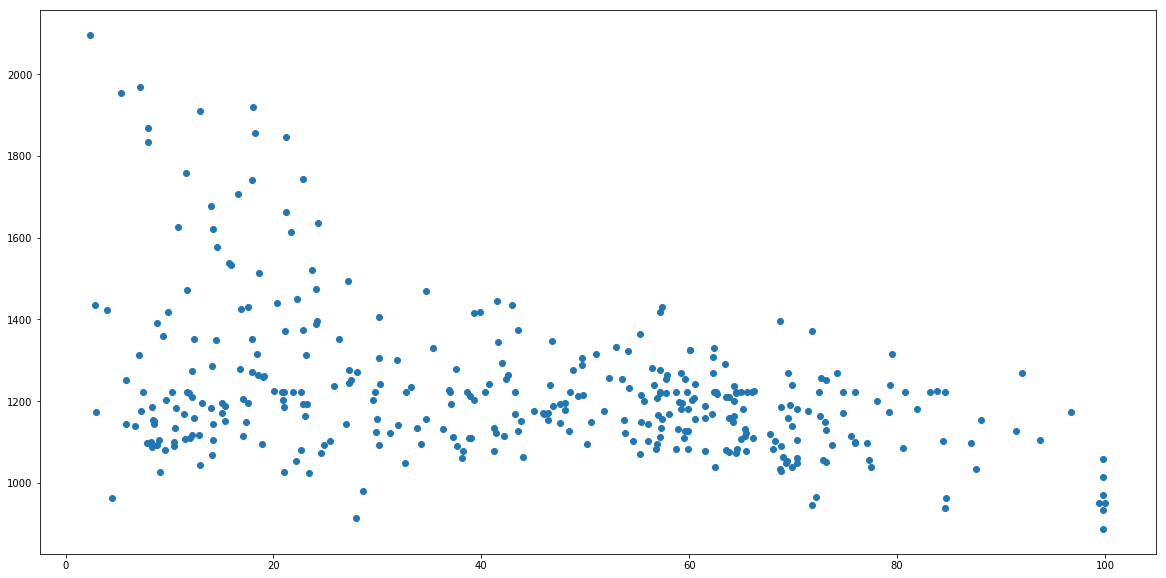

In [25]:
# scatter plot of hispanic_per vs. sat_score
plt.figure( figsize=( 20, 10 )) 
plt.scatter( combined['hispanic_per'], combined['sat_score'] )
plt.show()

# Findings
- There is tremendous negative correlation between '% of hispanic people' and 'sat score'
- In other words as hispanic people grow in % in school the low the 'sat score averge' will be.
- Let's find some schools with highest hispanic highest spanish percentage

In [39]:
output = combined.sort_values( 'hispanic_per')
print output[['school_name', 'hispanic_per'] ].iloc[-5:]

                                           school_name  hispanic_per
253                          Multicultural High School          99.8
89   Gregorio Luperon High School for Science and M...          99.8
176   Pan American International High School at Monroe          99.8
44                       Manhattan Bridges High School          99.8
286             Pan American International High School         100.0


In [43]:
# research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.

hisp_lt_10_sat_gt_1800 = combined[ ( combined['sat_score'] > 1800 ) & ( combined['hispanic_per'] < 10 ) ]
hisp_lt_10_sat_gt_1800['school_name']

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object

# Findings

- The schools in the above list are one of the most prestigious and sought after schools in New York, and they all have one thing in common that is they all have hispanic strength less than 10% of the whole school

# 4: Exploring Gender and SAT Scores

There are two columns that indicate the percentage of each gender at a school:

    male_per
    female_per

We can plot out the correlations between each percentage and sat_score.

## Instructions

    Investigate gender differences in SAT scores.
        Make a scatter plot of the correlations between the columns above and sat_score.
        Record your findings in a Markdown cell. Are there any unexpected correlations?
    Investigate schools with high SAT scores and a high female_per.
        Make a scatter plot of female_per vs. sat_score.
        What does the scatter plot show? Record any interesting observations in a Markdown cell.
    Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.
        Find the school names in the data.
        Use Wikipedia and Google to research the schools by name.
        Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

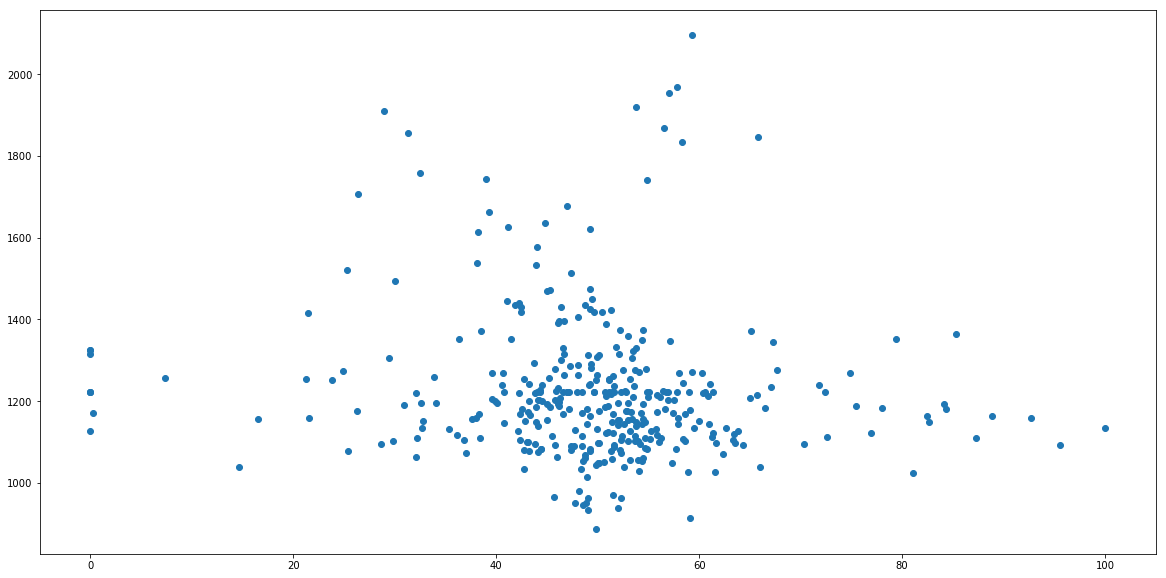

In [45]:
# sactter plot of male strength and sat_score
plt.figure( figsize=( 20, 10 ) )
plt.scatter( combined['male_per'], combined['sat_score'])

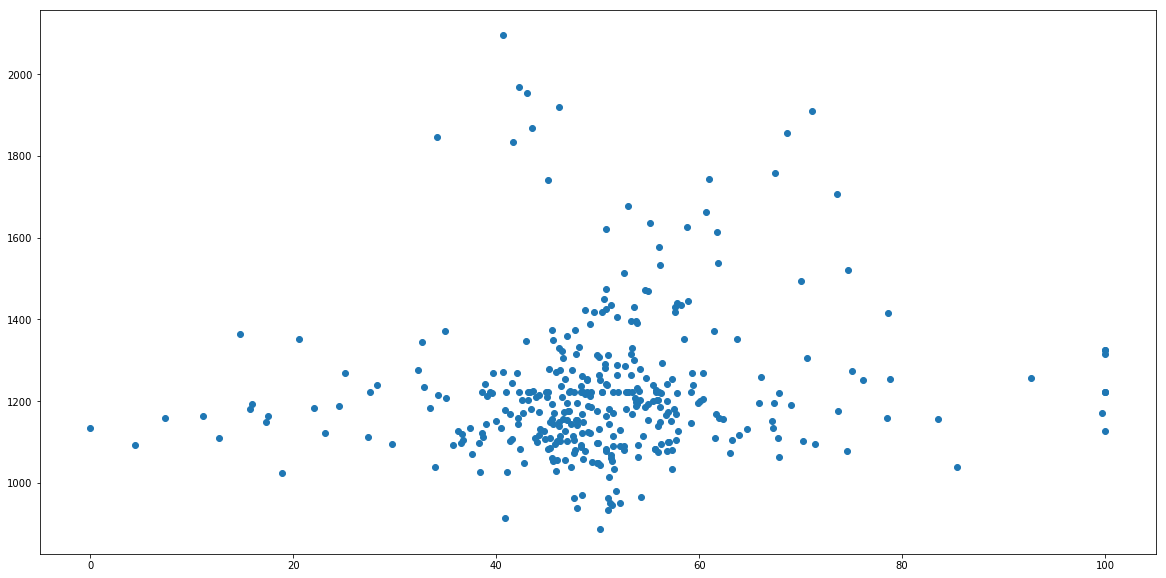

In [46]:
# sactter plot of female strength and sat_score
plt.figure( figsize=( 20, 10 ) )
plt.scatter( combined['female_per'], combined['sat_score'] )

In [48]:
fem_per_gt_60_satscore_gt_1700 = combined[ ( combined['female_per'] > 60 ) & ( combined['sat_score'] > 1700 ) ]
fem_per_gt_60_satscore_gt_1700['school_name']

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

# 5: Exploring AP Scores vs. SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

## Instructions

    Calculate the percentage of students in each school that took an AP exam.
        Divide the AP Test Takers column by the total_enrollment column.
            The column name AP Test Takers has a space at the end -- don't forget to add it!
        Assign the result to the ap_per column.
    Investigate the relationship between AP scores and SAT scores.
        Make a scatter plot of ap_per vs. sat_score.
        What does the scatter plot show? Record any interesting observations in a Markdown cell.

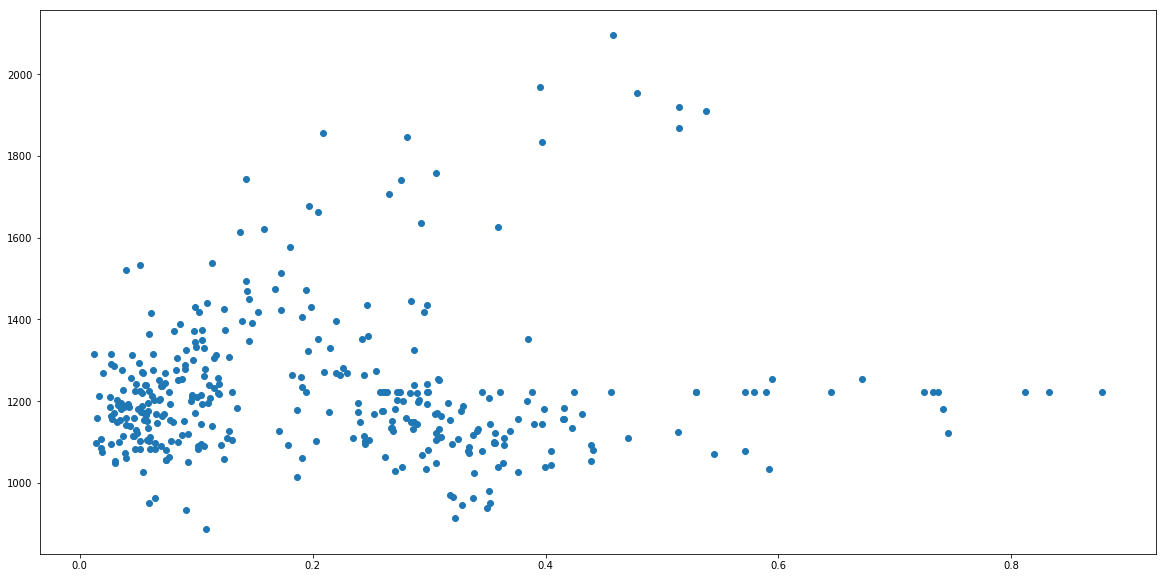

In [50]:
# TODO

plt.figure( figsize=( 20, 10 ) )
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
plt.scatter( combined['ap_per'], combined['sat_score'] )
plt.show()

# Findings

Students with less likely to apper in AP test are more likely to score high in sat 

# 6: Next Steps

We've done quite a bit of investigation into relationships between demographics and SAT scores in this guided project. There's still quite a bit of analysis left to do, however. Here are some potential next steps:

    Determing wheter there's a correlation between class size and SAT scores
    Figuring out which neighborhoods have the best schools
        If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
    Investigating the differences between parent, teacher, and student responses to surveys.
    Assigning scores to schools based on sat_score and other attributes.

We recommend creating a GitHub repository and placing this project there. It will help other people see your work, including employers. As you start to put multiple projects on GitHub, you'll have the beginnings of a strong portfolio.

You're welcome to keep working on the project here, but we recommend downloading it to your computer using the download icon above and working on it there.

We hope this guided project has been a good experience. Please email us at hello@dataquest.io if you'd like to share your work!